In [1]:
import matplotlib.pyplot as plt
import mdtraj as md
import seaborn as sns
from tqdm.notebook import tqdm

from rocketshp.trajectory import (
    compute_autocorrelation_DEPRECATED,
    compute_generalized_correlation_lmi,
)

# set seaborn theme
plt.rcParams.update({
    # "axes.prop_cycle": "cycler('color', ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9'])",
    "axes.prop_cycle": "cycler('color', ['#537EBA', '#FF9300', '#81AD4A', '#FF4115', '#1D2954', '#FFD53E'])", # simons foundation    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.size": 16,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.dpi": 300,
    "svg.fonttype": "none",
    })

In [2]:
# good examples:
## 1t7v_A -- two large domains
## 1tzw_A -- disordered ends
key = "1t7v_A"


sample_top = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}.pdb"
sample_traj = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}_prod_R2_fit.xtc"

traj = md.load_xtc(sample_traj, top=sample_top)

In [ ]:
from rocketshp.trajectory import display_trajectory

display_trajectory(traj)

NGLWidget(max_frame=10000)

In [4]:
gci_lm = compute_generalized_correlation_lmi(sample_top, sample_traj)

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     10001
@>: number of replicas:                     1
@>: using window length of 10001 simulation steps
@>: number or frames per replica:           10001
@>: first frame:                            0
@>: last frame:                             10001
@>: actual last frame:                      10001
@>: step:                                   1
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 10001
@>: step:        1
@>: reshaping coordinates...
@>: values array has shape (10001, 278, 3)


100%|██████████| 38781/38781 [00:20<00:00, 1911.77it/s]

@>: computing and storing distances...


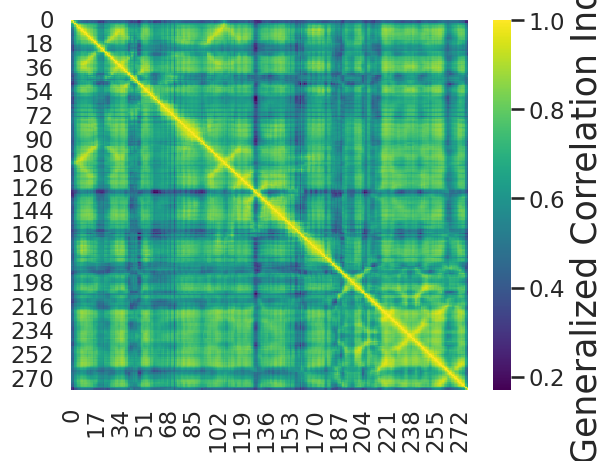

In [7]:
sns.heatmap(gci_lm, cmap="viridis", cbar_kws={'label': 'Generalized Correlation Index'})
plt.show()

In [8]:
from itertools import combinations

import numpy as np
from statsmodels.tsa.stattools import acf

from rocketshp.trajectory import compute_contacts

lag_list = [1, 10, 25, 50, 100, 250, 500, 1000]
contacts = compute_contacts(traj, normalized=True, ca_only=True)
correlations = np.zeros((contacts.shape[1], contacts.shape[1], len(lag_list)))
for c_i, c_j in combinations(range(contacts.shape[1]), 2):
    corrs_ = acf(contacts[:, c_i, c_j] - contacts[:, c_i, c_j].mean(), nlags=contacts.shape[0] - 1, fft=True)
    for l, lag in enumerate(lag_list):
        correlations[c_i, c_j, l] = corrs_[lag]
        correlations[c_j, c_i, l] = corrs_[lag]

In [11]:
def center(x):
    return x - x.mean()

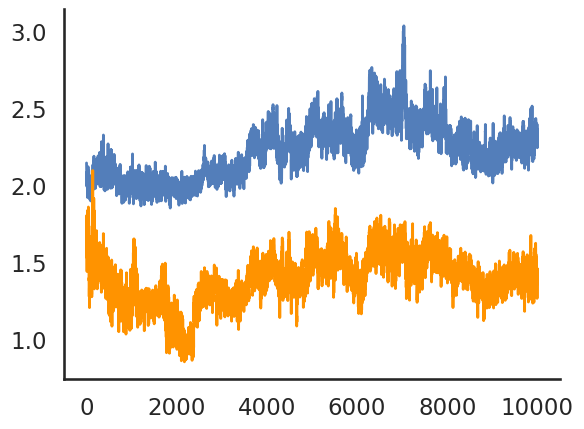

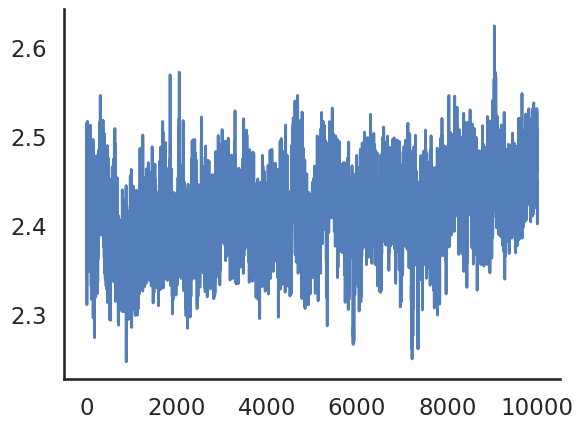

In [12]:


i = 126
j = 38
X = 0
Y = 1
Z = 2

plt.plot(traj.xyz[:, i, Z])
plt.plot(traj.xyz[:, j, Z])
plt.show()

plt.plot(contacts[:, i, j])
plt.show()

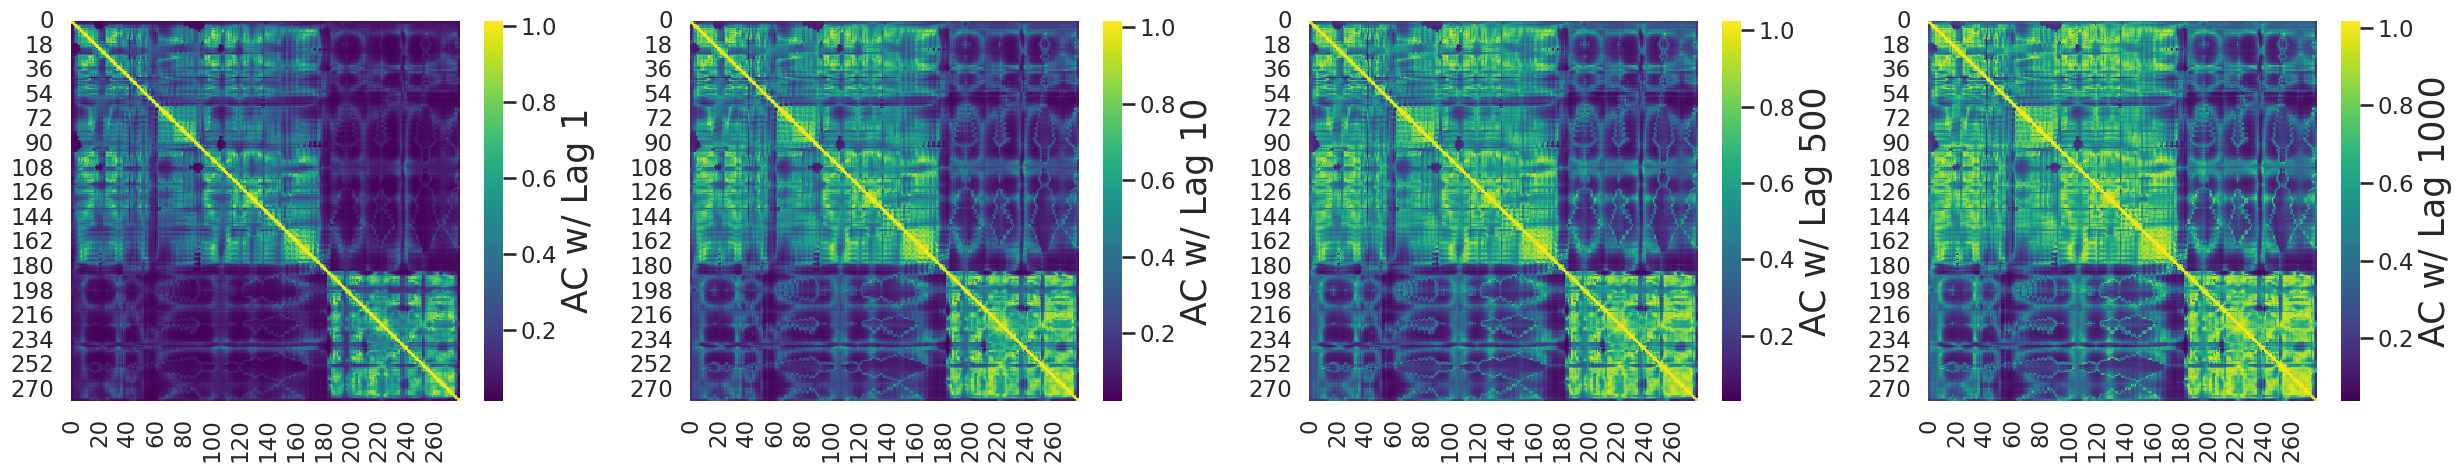

In [10]:
fig,ax = plt.subplots(1,4,figsize=(25,5))

for l, lag in enumerate([1,10,500,1000]):
    sns.heatmap(1 - correlations[:,:,l], cmap="viridis", cbar_kws={'label': f'AC w/ Lag {lag}'}, ax=ax[l])
plt.tight_layout()
plt.show()

---

In [14]:
from mdigest.core.correlation import DynCorr
from mdigest.core.parsetrajectory import MDS

mds = MDS()

# set number of replicas
mds.set_num_replicas(1) # use 2 if you have 2 replicas.

#load topology and trajectory files into MDS class
mds.load_system(sample_top, sample_traj)

#align trajectory
mds.align_traj(selection='name CA')

# set selections for MDS class
mds.set_selection('protein and name CA', 'protein')

#stride trajectory
mds.stride_trajectory(initial=0, final=-1, step=5)

  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     2000
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 2000 simulation steps
@>: number or frames per replica:           2000
@>: first frame:                            0
@>: last frame:                             10001
@>: actual last frame:                      10000
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278


In [15]:
dyncorr = DynCorr(mds)
dyncorr.parse_dynamics(scale=True, normalize=True, LMI='gaussian', MI='knn_5_2', DCC=True, PCC=True, VERBOSE=True, COV_DISP=True)

@>: sanity check pass: number of residues is same as number of nodes
@> -- shape of coordinates matrix: (1, 2000, 278, 3)
@> -- shape of coordinates_allreplicas matrix: (1, 2000, 834)
@> -- shape of displacements_allreplicas matrix: (1, 2000, 834)
@> -- shape of disp_from_mean_allreplicas matrix: (1, 2000, 278)
@> -- shape of distances_allreplicas matrix: (1, 278, 278)
@> -- shape of covar_disp_allreplicas (1, 278, 278)
@> -- shape of dcc_allreplicas matrix: (1, 278, 278)
@> -- shape of pcc_allreplicas matrix: (1, 278, 278)


@>: LMI/MI calculation ...
@>: begin frame: 0
@>: end   frame: 10000
@>: step:        5
@>: compute covariance of displacements...
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [11:02<00:00, 58.55it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (2000, 278, 3)


100%|██████████| 38781/38781 [00:03<00:00, 11060.97it/s]


@>: computing eigenvector centrality from lmi matrix
@>: computing and storing distances...
@>: computing normalized dynamical cross-correlation matrix
@>: computing pearson correlation matrix


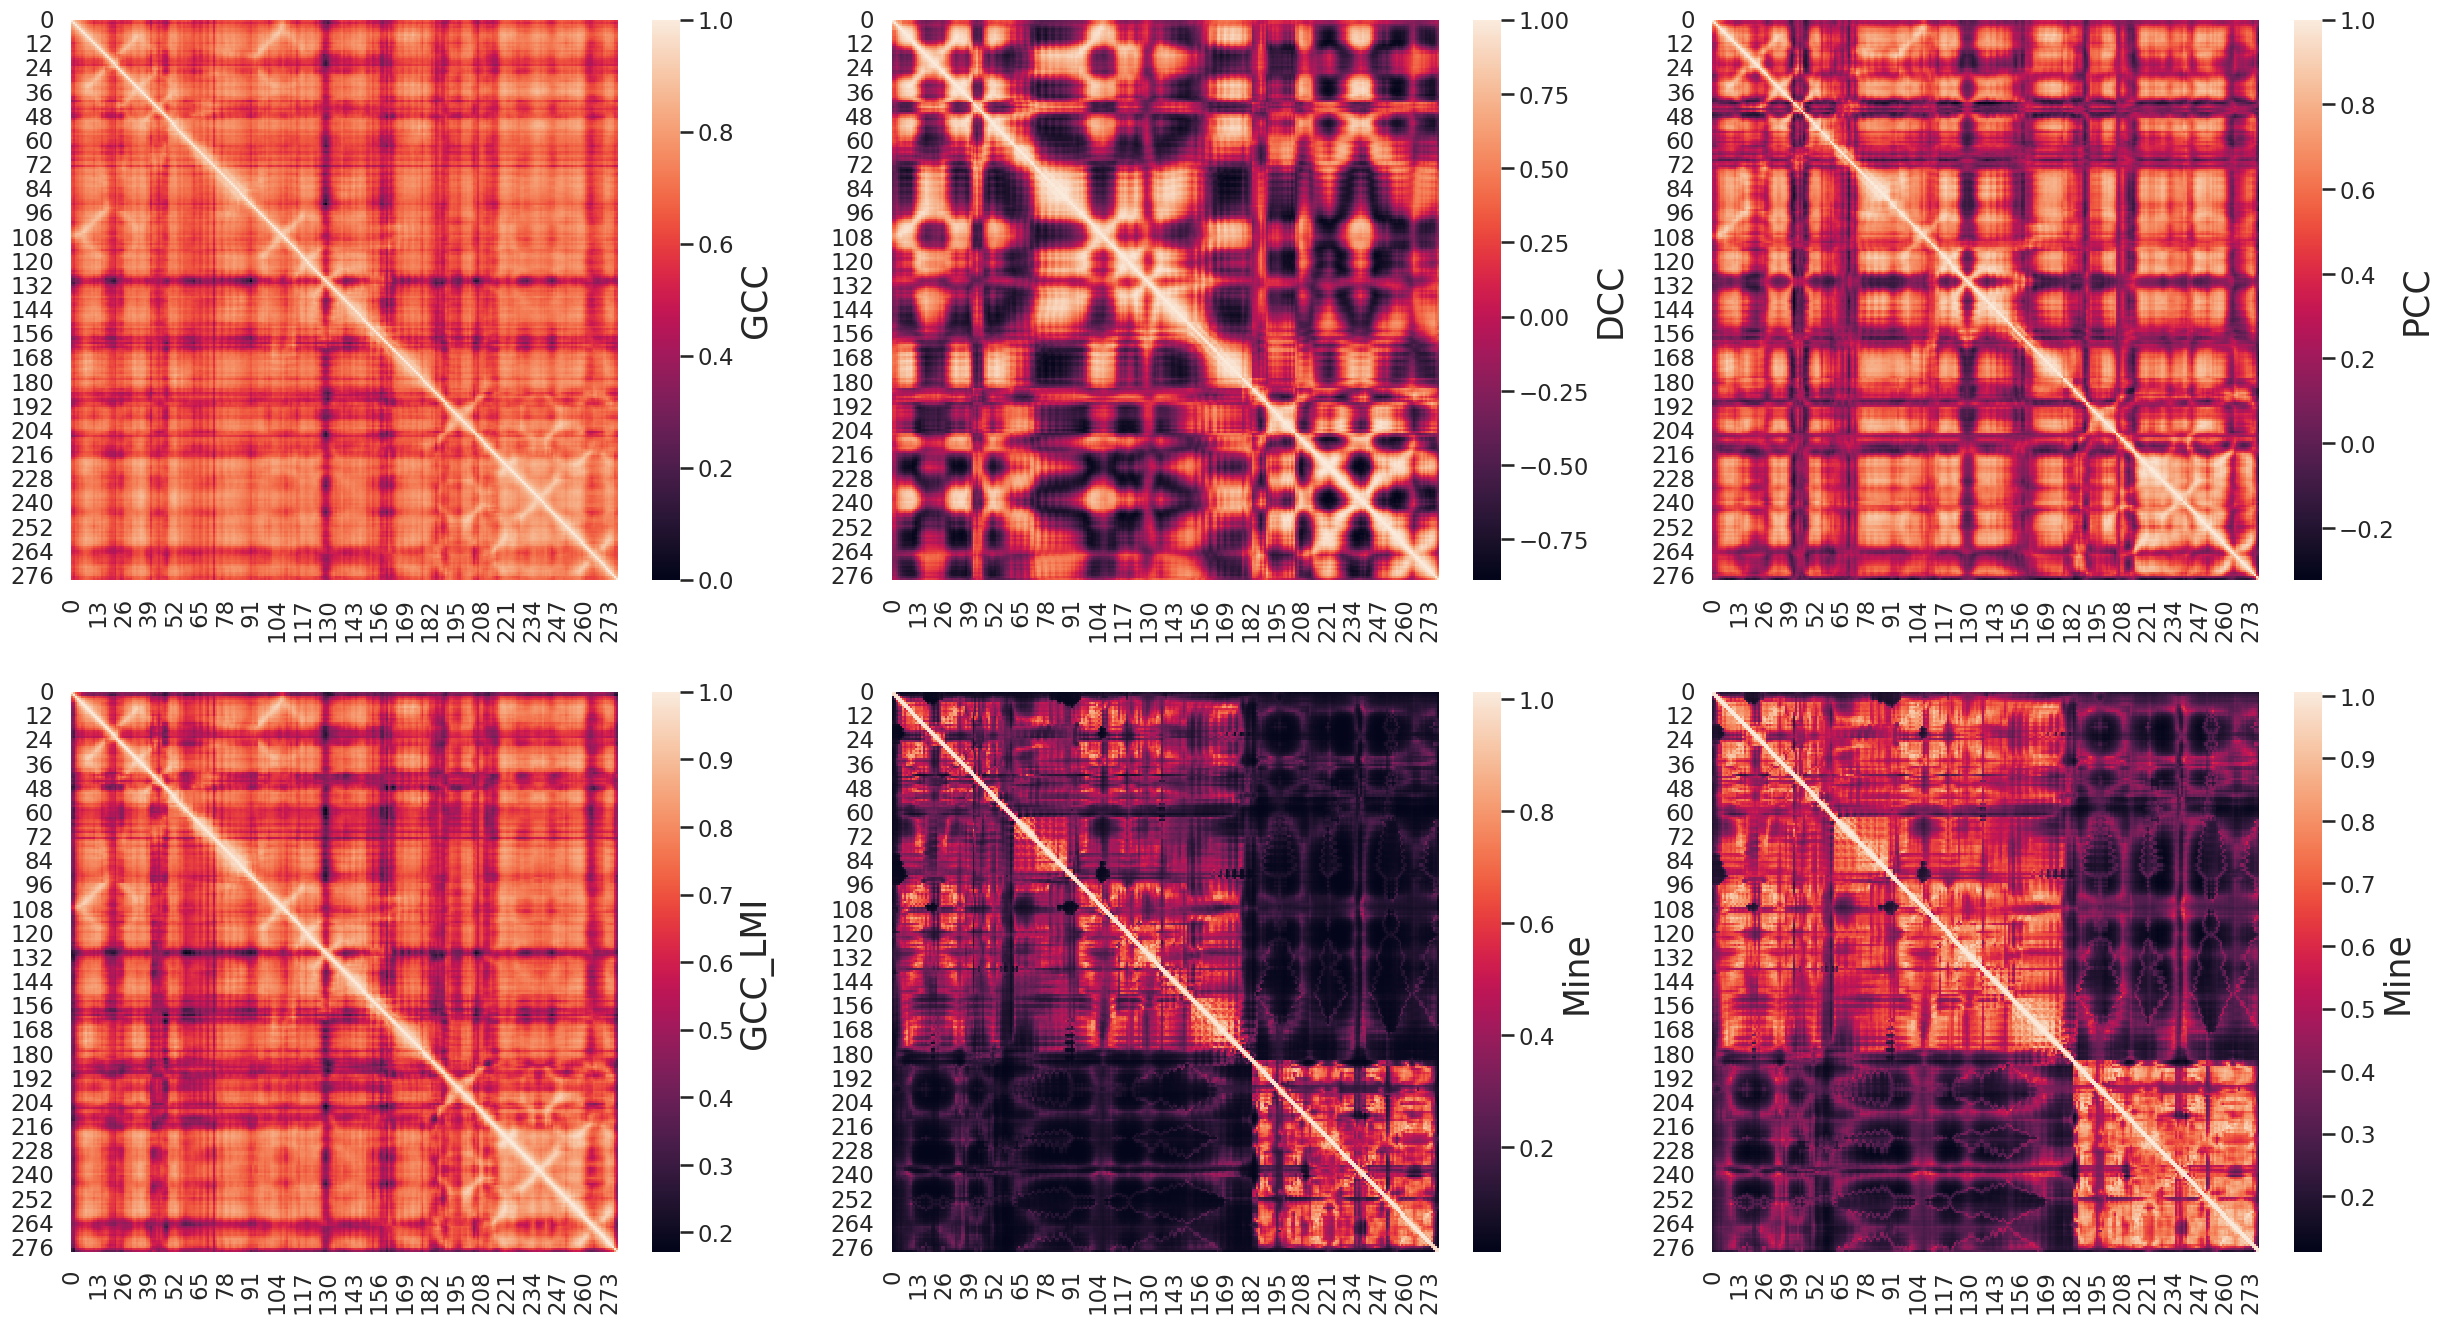

In [16]:
# set font scale
gcc = dyncorr.gcc_allreplicas["rep_0"]["gcc_mi"]
gcc_lmi = dyncorr.gcc_allreplicas["rep_0"]["gcc_lmi"]
dcc = dyncorr.dcc_allreplicas["rep_0"]
pcc = dyncorr.pcc_allreplicas["rep_0"]
ac_dep = compute_autocorrelation_DEPRECATED(traj)
fig,ax = plt.subplots(2,3,figsize=(30,16))
sns.heatmap(gcc, ax=ax[0][0], cbar_kws={'label': 'GCC'})
sns.heatmap(gcc_lmi, ax=ax[1][0], cbar_kws={'label': 'GCC_LMI'})
sns.heatmap(dcc, ax=ax[0][1], cbar_kws={'label': 'DCC'})
sns.heatmap(pcc, ax=ax[0][2], cbar_kws={'label': 'PCC'})
sns.heatmap(1 - ac_dep, ax=ax[1][1], cbar_kws={'label': 'Mine'})
sns.heatmap(np.sqrt(1 - ac_dep), ax=ax[1][2], cbar_kws={'label': 'Mine'})
plt.show()

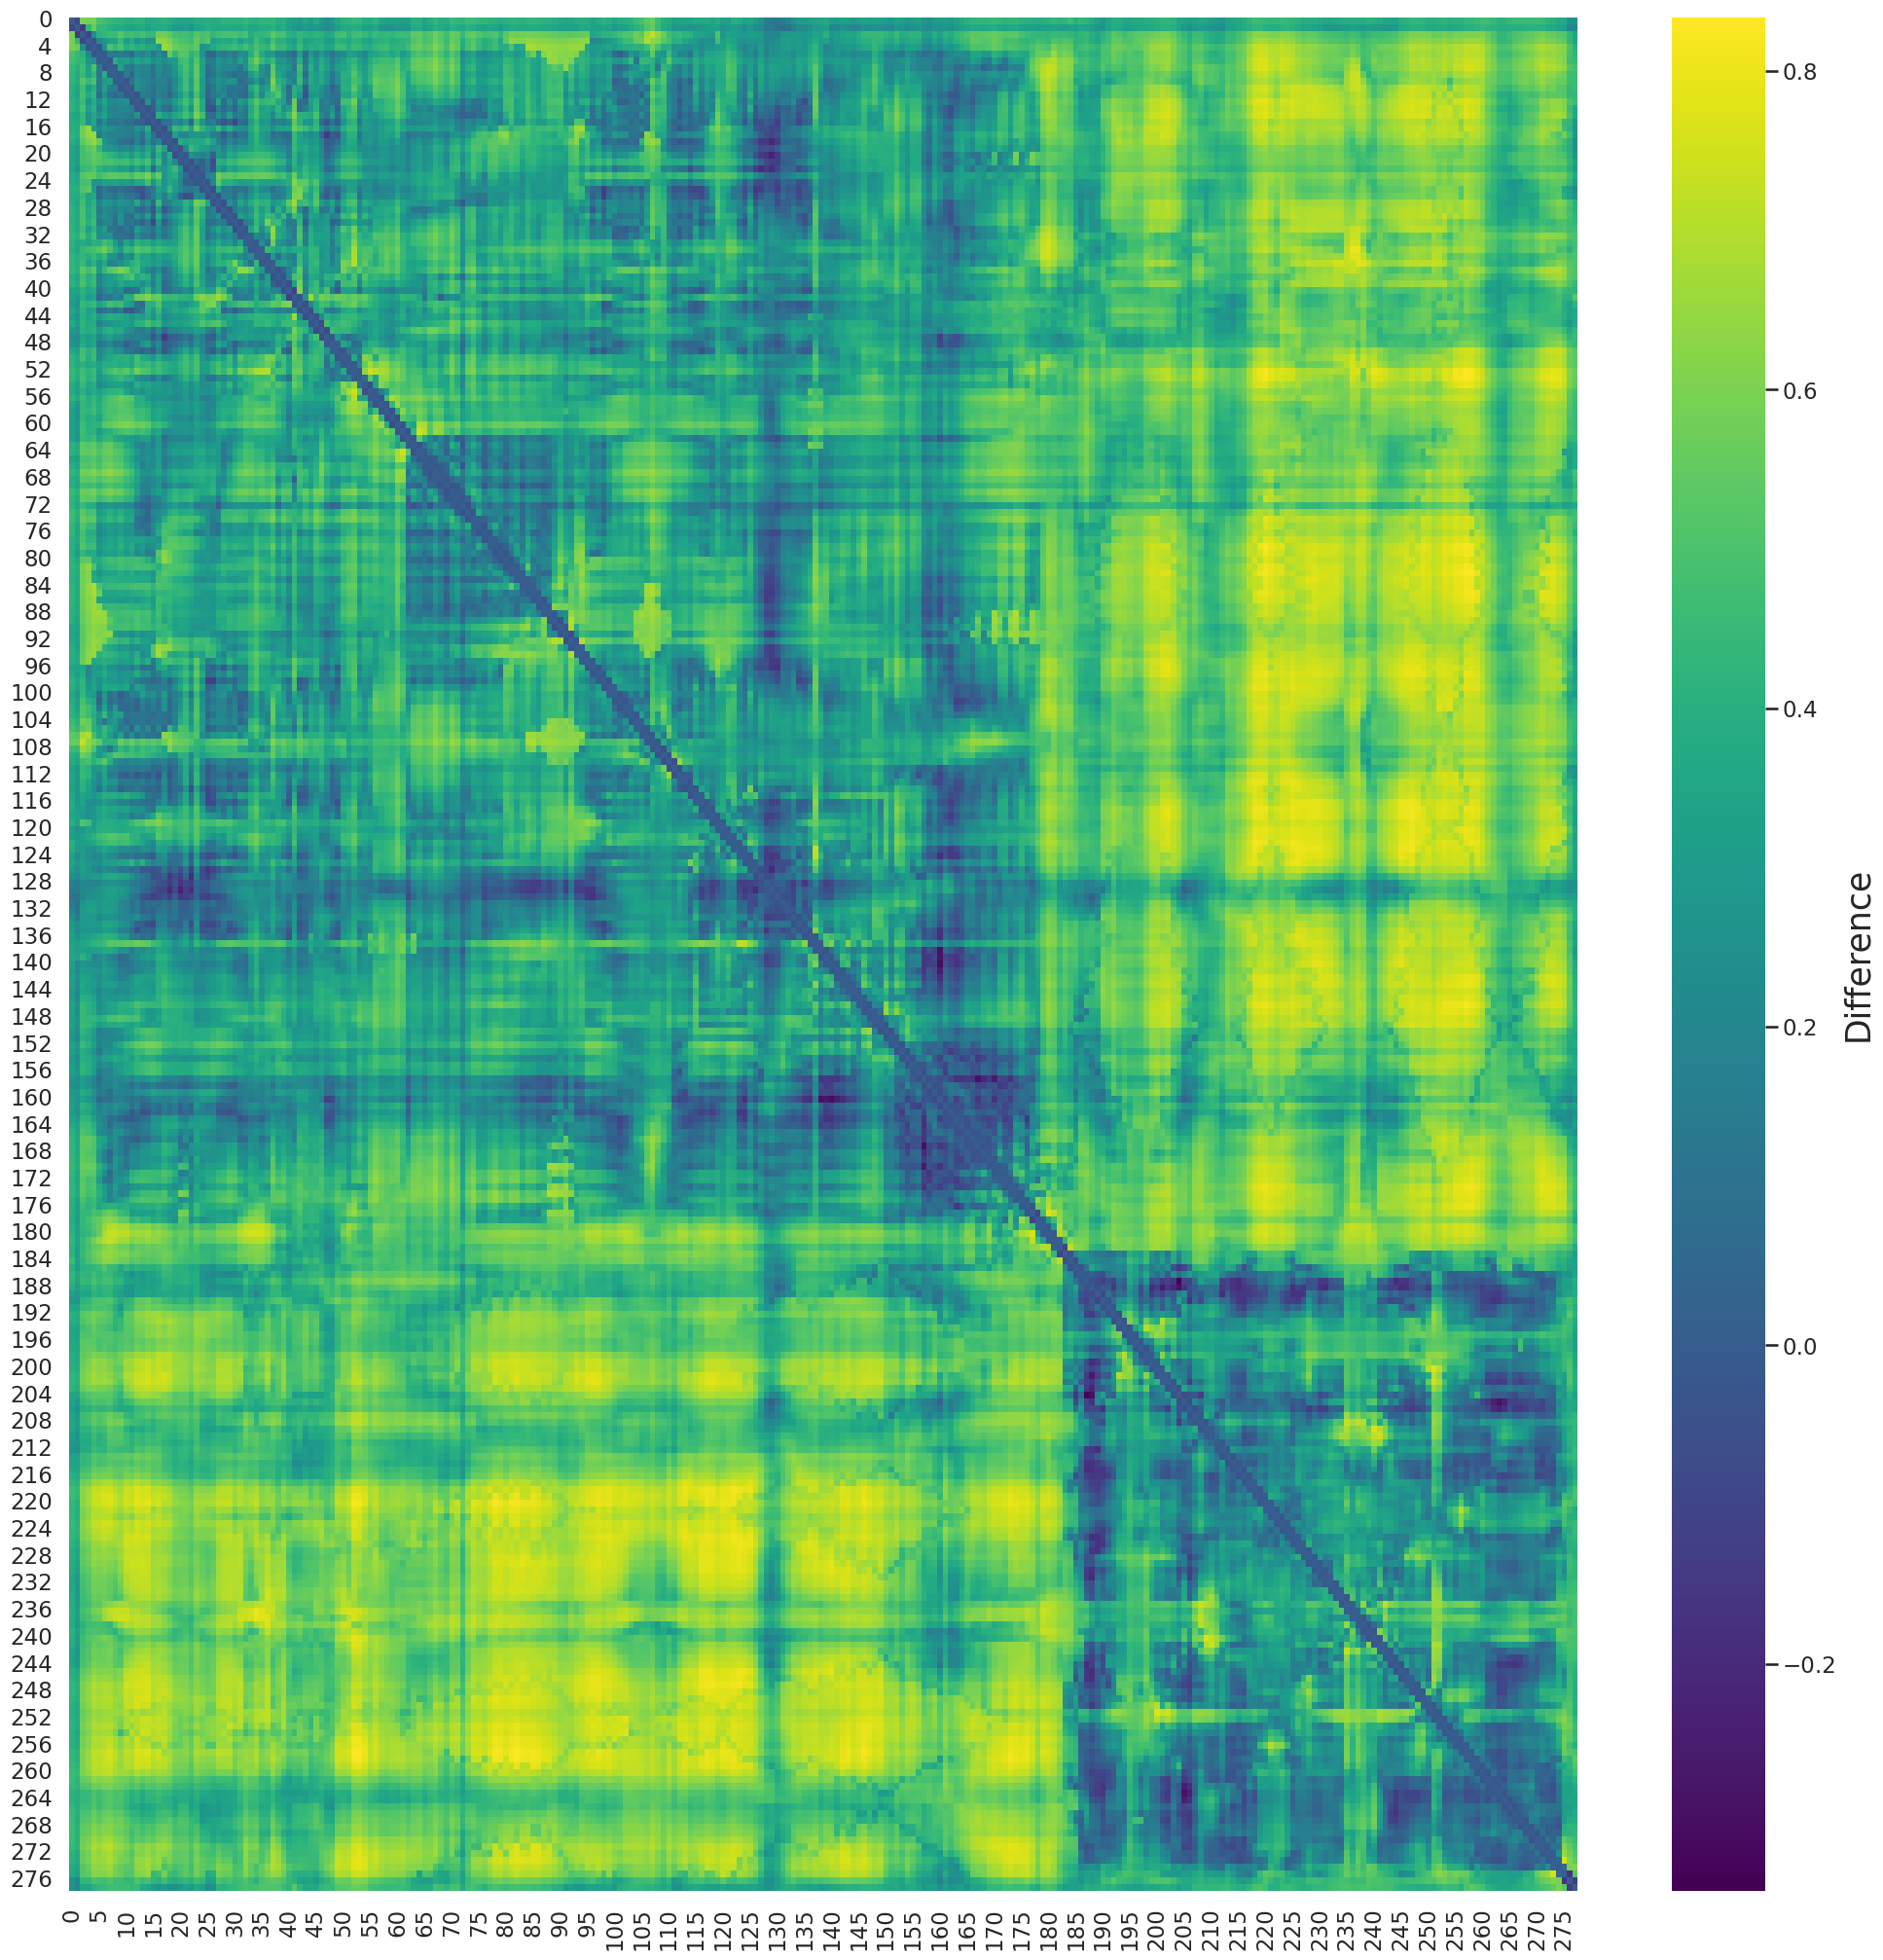

In [17]:
fig,ax = plt.subplots(1,1,figsize=(25,25))
difference = gcc_lmi - (1 - ac_dep)
sns.heatmap(difference, cmap="viridis", cbar_kws={'label': 'Difference'})
plt.show()

(array([26558., 14858.,  9494.,  8366.,  7028.,  4682.,  3224.,  1564.,
          638.,   872.]),
 array([0.01229455, 0.11241282, 0.21253108, 0.31264935, 0.41276762,
        0.51288588, 0.61300415, 0.71312242, 0.81324068, 0.91335895,
        1.01347722]),
 <BarContainer object of 10 artists>)

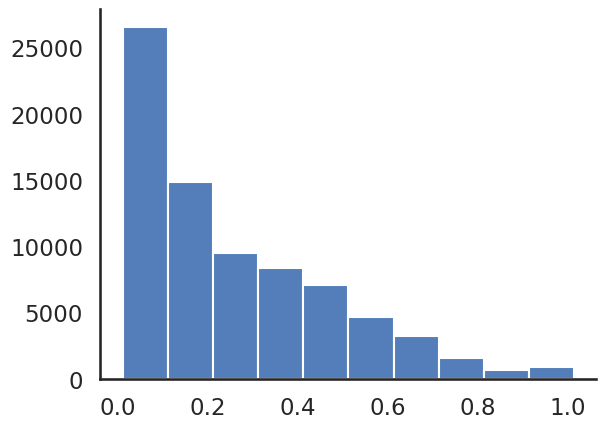

In [18]:
plt.hist((1 - ac_dep).flatten())

(array([ 7176., 12816., 12420.,  9754.,  8720.,  9002.,  8134.,  5446.,
         2614.,  1202.]),
 array([0.11088078, 0.20046431, 0.29004784, 0.37963137, 0.46921489,
        0.55879842, 0.64838195, 0.73796547, 0.827549  , 0.91713253,
        1.00671606]),
 <BarContainer object of 10 artists>)

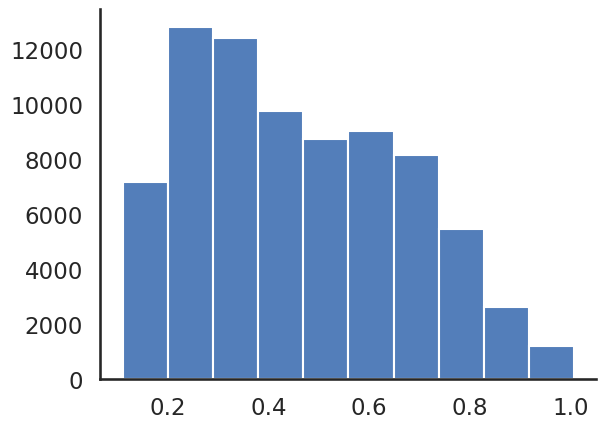

In [19]:
plt.hist(np.sqrt(1 - ac_dep).flatten())

## Compare how network changes on trajectory subsets

In [4]:
import mdtraj as md
import numpy as np
from mdigest.core.correlation import DynCorr
from mdigest.core.parsetrajectory import MDS
from tqdm import tqdm

In [3]:
key = "1t7v_A"

sample_top = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}.pdb"
sample_traj = f"/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/{key[:2]}/{key}_prod_R2_fit.xtc"

traj = md.load_xtc(sample_traj, top=sample_top)

In [9]:


# sample_networks = []
step = 5

for _ in tqdm(range(50-17)):

    start = np.random.randint(0, traj.n_frames // 2)
    duration = np.random.randint(1, max(5 * step, traj.n_frames // 2 - start))

    mds = MDS()

    # set number of replicas
    mds.set_num_replicas(1) # use 2 if you have 2 replicas.

    #load topology and trajectory files into MDS class
    mds.load_system(sample_top, sample_traj)

    #align trajectory
    mds.align_traj(selection='name CA')

    # set selections for MDS class
    mds.set_selection('protein and name CA', 'protein')

    #stride trajectory
    mds.stride_trajectory(initial=start, final=start+duration, step=step)
    dyncorr = DynCorr(mds)
    dyncorr.parse_dynamics(scale=True, normalize=True, LMI='gaussian', MI='knn_5_2', DCC=False, PCC=False, VERBOSE=False, COV_DISP=False)
    gcc_lmi = dyncorr.gcc_allreplicas["rep_0"]["gcc_lmi"]

    sample_networks.append(gcc_lmi)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     344
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 0 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 344 simulation steps
@>: number or frames per replica:           344
@>: first frame:                            1936
@>: last frame:                             3656
@>: actual last frame:                      1720
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 1936
@>: end   frame: 3656
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [01:37<00:00, 398.45it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (344, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 22666.77it/s]


@>: computing eigenvector centrality from lmi matrix


  3%|▎         | 1/33 [01:48<57:52, 108.53s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     9
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: -1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 9 simulation steps
@>: number or frames per replica:           9
@>: first frame:                            3896
@>: last frame:                             3940
@>: actual last frame:                      43
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 3896
@>: end   frame: 3941
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:15<00:00, 2525.69it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (9, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 34076.77it/s]


@>: computing eigenvector centrality from lmi matrix


  6%|▌         | 2/33 [02:14<30:58, 59.95s/it] 

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     43
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 43 simulation steps
@>: number or frames per replica:           43
@>: first frame:                            2285
@>: last frame:                             2501
@>: actual last frame:                      215
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 2285
@>: end   frame: 2500
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:18<00:00, 2056.23it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (43, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 33902.46it/s]


@>: computing eigenvector centrality from lmi matrix


  9%|▉         | 3/33 [02:43<23:00, 46.01s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     469
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: -2 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 469 simulation steps
@>: number or frames per replica:           469
@>: first frame:                            963
@>: last frame:                             3306
@>: actual last frame:                      2342
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 963
@>: end   frame: 3308
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [02:32<00:00, 254.49it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (469, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 19492.45it/s]


@>: computing eigenvector centrality from lmi matrix


 12%|█▏        | 4/33 [05:27<44:44, 92.58s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     432
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 432 simulation steps
@>: number or frames per replica:           432
@>: first frame:                            417
@>: last frame:                             2578
@>: actual last frame:                      2160
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 417
@>: end   frame: 2577
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [02:12<00:00, 293.13it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (432, 278, 3)


100%|██████████| 38781/38781 [00:02<00:00, 18340.64it/s]


@>: computing eigenvector centrality from lmi matrix


 15%|█▌        | 5/33 [07:51<51:50, 111.10s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     105
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 0 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 105 simulation steps
@>: number or frames per replica:           105
@>: first frame:                            4267
@>: last frame:                             4792
@>: actual last frame:                      525
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 4267
@>: end   frame: 4792
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:29<00:00, 1325.94it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (105, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 26889.48it/s]


@>: computing eigenvector centrality from lmi matrix


 18%|█▊        | 6/33 [08:31<39:07, 86.94s/it] 

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     12
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 0 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 12 simulation steps
@>: number or frames per replica:           12
@>: first frame:                            4851
@>: last frame:                             4911
@>: actual last frame:                      60
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 4851
@>: end   frame: 4911
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:15<00:00, 2469.58it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (12, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 35639.55it/s]


@>: computing eigenvector centrality from lmi matrix


 21%|██        | 7/33 [08:58<29:05, 67.12s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     10
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 0 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 10 simulation steps
@>: number or frames per replica:           10
@>: first frame:                            3447
@>: last frame:                             3497
@>: actual last frame:                      50
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 3447
@>: end   frame: 3497
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:15<00:00, 2498.53it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (10, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 34523.00it/s]


@>: computing eigenvector centrality from lmi matrix


 24%|██▍       | 8/33 [09:24<22:33, 54.13s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     26
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: -1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 26 simulation steps
@>: number or frames per replica:           26
@>: first frame:                            1535
@>: last frame:                             1664
@>: actual last frame:                      128
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 1535
@>: end   frame: 1665
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [00:16<00:00, 2335.36it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (26, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 33885.75it/s]


@>: computing eigenvector centrality from lmi matrix


 27%|██▋       | 9/33 [09:51<18:18, 45.76s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     373
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: -1 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 373 simulation steps
@>: number or frames per replica:           373
@>: first frame:                            3083
@>: last frame:                             4947
@>: actual last frame:                      1863
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 3083
@>: end   frame: 4948
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [01:43<00:00, 372.96it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (373, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 20197.81it/s]


@>: computing eigenvector centrality from lmi matrix


 30%|███       | 10/33 [11:47<25:48, 67.33s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     278
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: 0 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 278 simulation steps
@>: number or frames per replica:           278
@>: first frame:                            2821
@>: last frame:                             4211
@>: actual last frame:                      1390
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 2821
@>: end   frame: 4211
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


100%|██████████| 38781/38781 [01:15<00:00, 512.79it/s]


@>: computing eigenvector centrality from mi matrix
@>: values array has shape (278, 278, 3)


100%|██████████| 38781/38781 [00:01<00:00, 24068.00it/s]


@>: computing eigenvector centrality from lmi matrix


 33%|███▎      | 11/33 [13:14<26:53, 73.32s/it]

@>: computing and storing distances...


  0%|          | 0/10001 [00:00<?, ?it/s]

@>: total number of frames in trajectory file: 10001
@>: length of selected trajectory segment:     3
@>: WARNING: the segmented trajectory has an uneven number of frames
@>: WARNING: -2 last frame/s will be excluded
@>: number of replicas:                     1
@>: using window length of 3 simulation steps
@>: number or frames per replica:           3
@>: first frame:                            4976
@>: last frame:                             4989
@>: actual last frame:                      12
@>: step:                                   5
@>: number of residues in selected atom group: 278
@>: number of nodes    in selected atom group: 278
@>: number of elements in selected atom group: 278
@>: sanity check pass: number of residues is same as number of nodes


@>: LMI/MI calculation ...
@>: begin frame: 4976
@>: end   frame: 4991
@>: step:        5
@>: reshaping coordinates...
@>: estimate == 2


 33%|███▎      | 11/33 [13:22<26:45, 72.96s/it]


ValueError: k must be less than or equal to the number of training points

In [ ]:
import pickle as pk

from rocketshp import config

with open(config.PROCESSED_DATA_DIR / "atlas" / f"mdigest_resample_{key}.pkl", "wb") as f:
    pk.dump(sample_networks, f)
with open(config.PROCESSED_DATA_DIR / "atlas" / f"mdigest_resample_{key}.pkl", "rb") as f:
    sample_networks = pk.load(f)

In [ ]:
print(len(sample_networks))

17
